<a href="https://colab.research.google.com/github/hrbae/LG_AI_training/blob/main/M2_System%20Optimization%20by%20ML/LG_Day2_Metric%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import cifar10

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.manifold import TSNE

import random

import seaborn as sns

#Linearly Separable & Un-separable

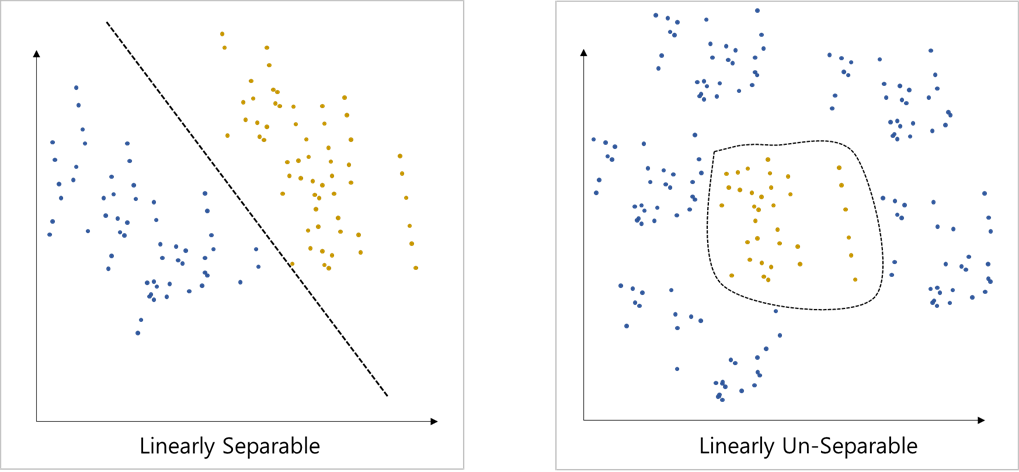

#Linearly Un-Separable 문제를 해결하는 방법

### 1. Learning non-linear function
* 예측 모델이 많은 파라미터(가중치)를 가지며, 이를 최적화 하는 것은 쉽지 않음

# ***2. Data transformation***
* 특정한 기준(유사도 등)을 바탕으로 입력 데이터를 선형 분리가 가능하도록 변환
 * 예측 모델의 파라미터가 적어, 최적화가 쉬움

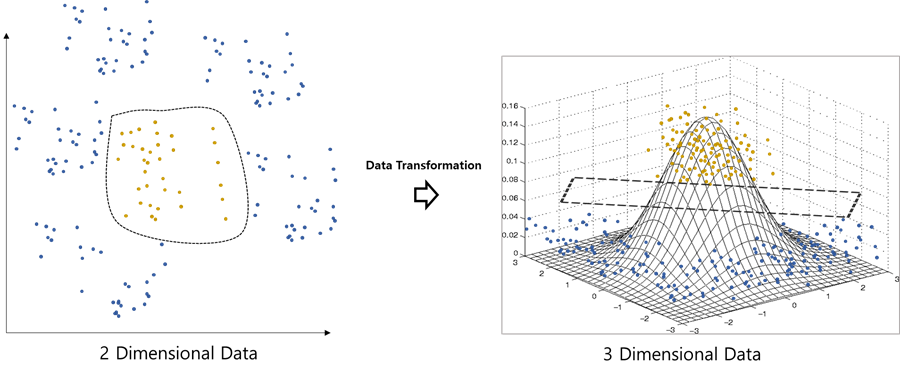

# 그렇다면, 어떻게 데이터를 변환할 것인가?

* ### 자연어 처리와 같은 다양한 분야에서는 의미론적인 유사도를 바탕으로 데이터를 변환함

---

### Metric Learning: 비 선형 공간에 표현된 입력 데이터 사이에 대한 유사도를 학습하는 것을 목적으로 함

* 데이터 사이에 존재하는 의미론적인 유사도를 학습하는 것!

* 비 선형 공간에 변환된 입력 데이터를 선형 분리가 가능하도록 만들어, 예측 성능을 향상

* 주로 활용되는 분야
 * 많은 분야에 적용 가능하지만, 특히 안면 인식과 같은 분야에서 활발한 연구가 진행됨

#왜 안면 인식에서 주로 활용되는가?

* 안면 인식이란, 스마트폰 등의 서비스에서 보안과 같은 목적으로 활용될 수 있음
* softmax 함수를 활용한 다중 분류 문제로 해결할 경우, 닫힌 데이터셋에서는 활용 가능할 수 있음. 하지만, Label의 종류는 매우 다양하기 때문에 학습되지 않은 새로운 Label에 대해서는 강건한 예측이 불가능함
 * 해결책: Metric Learning을 활용하여 데이터 사이에 유사도를 학습하고, 유사도 점수(임계값) 혹은 K-NN 등과 같은 알고리즘을 활용하여 문제 해결

# *실습의 목적*
* Metric Learning을 활용하여 데이터를 잠재 공간으로 변환하고, 이를 시각적으로 확인

---

# *실습 내용*
* **Siamese Network**
 * (Convolutional Network)
* **Contrastive Loss Function**
 * (Label을 활용하여 의미론적인 유사도 반영)
* **Data Sampling**
 * (semi-hard mining의 필요성)

In [ ]:
# CIFAR-10 데이터셋 로드
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 클래스 레이블 정의
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
# 실습 난이도를 보다 쉽게 하기 위해, dog부터 truck까지의 label 제거
x_train = np.delete(x_train, np.where(y_train >= 5)[0], axis = 0)
y_train = np.delete(y_train, np.where(y_train >= 5)[0]).reshape(-1, 1)

x_test = np.delete(x_test, np.where(y_test >= 5)[0], axis = 0)
y_test = np.delete(y_test, np.where(y_test >= 5)[0]).reshape(-1, 1)

In [ ]:
#학습 데이터 차원
#해석: (데이터 갯수, 픽셀 수, 픽셀 수, 채널 수) -> (32, 32, 3) 형태의 이미지가 25000개 있다는 뜻
print(x_train.shape)
print(y_train.shape)

#테스트 데이터 차원
print(x_test.shape)
print(y_test.shape)

(25000, 32, 32, 3)
(25000, 1)
(5000, 32, 32, 3)
(5000, 1)


In [ ]:
#학습 데이터 분포
#픽셀 값에 대한 최소 최대 평균 편차
print('Training dset')
print('Min: ', x_train.min())
print('Max: ', x_train.max())
print('Mean: ', np.round(x_train.mean(), 2))
print('Std: ', np.round(x_train.std(), 2), '\n\n')

#테스트 데이터 분포
print('Test dset')
print('Min: ', x_test.min())
print('Max: ', x_test.max())
print('Mean: ', np.round(x_test.mean(), 2))
print('Std: ', np.round(x_test.std(), 2))

Training dset
Min:  0
Max:  255
Mean:  121.3
Std:  63.86 


Test dset
Min:  0
Max:  255
Mean:  121.69
Std:  63.66


In [ ]:
#학습 데이터, 테스트 데이터 정규화
#모든 값의 범위를 0부터 1까지 동일하게 설정
x_train = x_train / 255
x_test = x_test / 255

In [ ]:
#앞서 정의한 class_labels와 특정한 수를 매칭시킬 수 있도록 딕셔너리 생성
#생성 원인: 추후 positive sample 혹은 negative sample을 설정할 때 설정한 수를 기준으로 처리할 것
#-> 영어로 해도 되지만, 연산 속도에 차이가 있을 것임

d = dict()
for i in range(5):
  d[i] = class_labels[i]

In [ ]:
#딕셔너리의 key와 values를 비교
print(list(d.keys()), '\n', list(d.values()))

NameError: ignored

In [ ]:
#딕셔너리 확인
print(d)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer'}


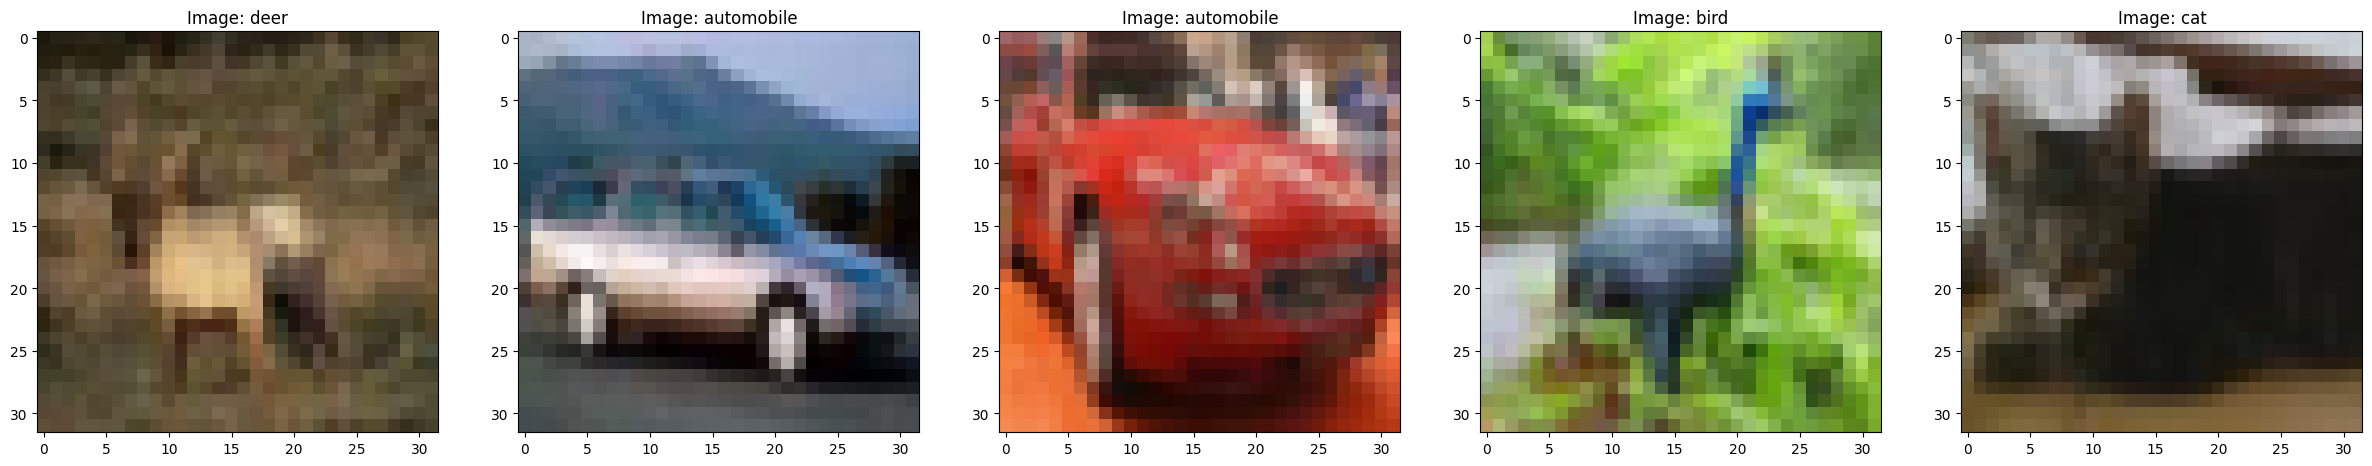

In [ ]:
#train 데이터 5개 불러와서, 시각화 진행

plt.figure(figsize = (30, 20)) # 전체 그림의 크기 설정

for i in range(5): # 5번 반복
  plt.subplot(1, 5, i+1) # 총 5개 그림(1행 5열)을 그리고, 해당 인덱스에 위치시킬 것
  plt.imshow(x_train[i]) # index에 해당하는 그림 출력
  plt.title('Image: '+d[y_train[i].reshape(1)[0]]) # 그림의 제목은 해당 그림의 정답으로 설정

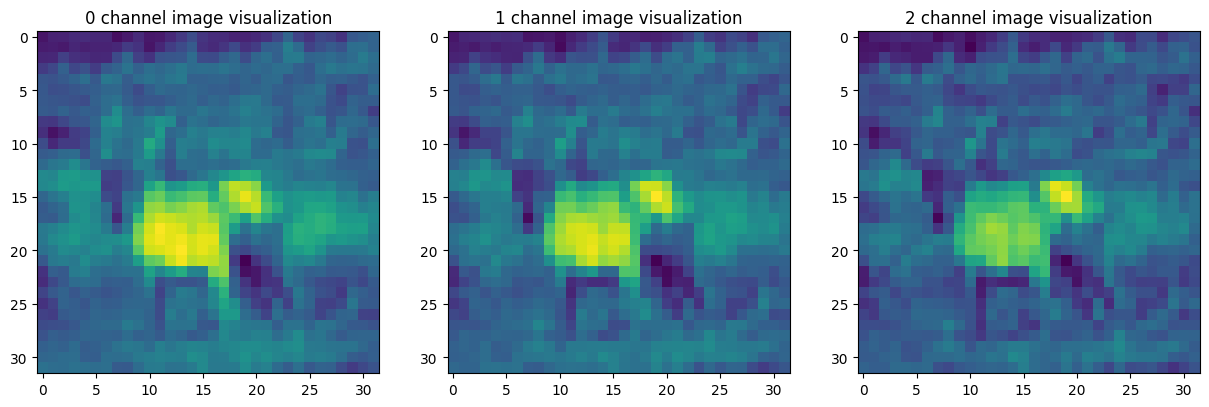

In [ ]:
#하나의 그림을 고른 후, 채널에 따라서 시각화
#값의 분포가 채널에 따라 살짝 다름

plt.figure(figsize = (15, 12))
for i in range(3):
  plt.subplot(1, 3, i+1)
  plt.imshow(x_train[0][:, :, i])
  plt.title(str(i)+' channel image visualization')

In [ ]:
x_train[0][:, :, 0] # 0번째 그림에서 첫번째 채널(RGB)에 있는 데이터
#x_train[0][:, :, 1] # 0번째 그림에서 두번째 채널(RGB)에 있는 데이터
#x_train[0][:, :, 2] # 0번째 그림에서 세번째 채널(RGB)에 있는 데이터

array([[0.10980392, 0.14509804, 0.14901961, ..., 0.29803922, 0.31764706,
        0.33333333],
       [0.12941176, 0.13333333, 0.1254902 , ..., 0.37254902, 0.37647059,
        0.33333333],
       [0.15294118, 0.15686275, 0.22352941, ..., 0.36470588, 0.41960784,
        0.37254902],
       ...,
       [0.3254902 , 0.34117647, 0.32941176, ..., 0.38823529, 0.35294118,
        0.31764706],
       [0.34509804, 0.35294118, 0.36470588, ..., 0.31372549, 0.29803922,
        0.32156863],
       [0.38039216, 0.36862745, 0.36470588, ..., 0.21176471, 0.24705882,
        0.28235294]])

#Dataset
* Data Sampling

In [ ]:
class Img_dset(Dataset):

  def __init__(self, x, y, d, Training_):
    '''
    Deep Metric Learning의 손실함수는 Label이 Positive인지, 혹은 Negative인지에 대한 정보가 필요함
    cifar10 데이터셋은 단지 각 이미지가 어떤 종류를 가지는지에 대해서 표현되어 있음

    두 데이터를 묶고, 두 데이터가 동일한 Label이면 Positive로 표현하고 다른 Label이면 Negative로 표현하기 위해 전처리가 필요함
    
    class Img_dset은 위와 같은 과정을 수행해주는 클래스임
    '''

    self.x = x

    self.y = y

    self.sample = list() #sampling을 진행하고, 추가할 리스트 생성

    self.List = list(d.keys()) # 위에서 정의했던 딕셔너리의 키를 리스트 형태로 사용할 것

    self.Training_ = Training_ # Training, Test에 따라서 서로 다른 샘플링을 수행할 것

    if self.Training_ == False:

      print('Test Data Loader ...')

      self.tx1 = self.x[:len(self.x)//2]
      self.tx2 = self.x[len(self.x)//2:]

      self.ty1 = self.y[:len(self.x)//2]
      self.ty2 = self.y[len(self.x)//2:]

      for t in range(len(self.tx1)):
        self.sample.append((torch.tensor(self.tx1[t], dtype = torch.float32),
                            torch.tensor(self.tx2[t], dtype = torch.float32), self.ty1[t], self.ty2[t]))

    else:

      print('Train Data Loader ...')

      for _ in list(self.List):
        #xx는 정의한 딕셔너리의 key와 동일한 샘플을 의미함
        xx = self.x[np.where(self.y == _)[0]]
        
        #xx는 전체 이미지를 의미하기 때문에, 이를 2등분해서 sample pair라고 하는 쌍을 만들어줘야 함

        x1 = xx[:len(xx)//2]
        x2 = xx[len(xx)//2:]

        for pos_samp in range(len(x1)//2):
          '''
          Positive sampling
          sample 1과, sample 2가 서로 동일한 pair이기 때문에 [0]이라는 Label을 할당할 것임
          '''
          self.sample.append((torch.tensor(x1[pos_samp], dtype = torch.float32),
                              torch.tensor(x2[pos_samp], dtype = torch.float32),
                              torch.tensor([0])))
        
        #neg_xx는 Negative sample을 의미함
        neg_xx = self.x[np.where(self.y != _)[0]]
        #Negative sample은 많기때문에, 그중 일부만 사용할 것(전체의 25%만 사용한다는 뜻이 결국 [:len(neg_xx)//4]와 같음)
        neg_x1 = neg_xx[:len(neg_xx)//4]

        for neg_samp in range(len(neg_x1)):
          '''
          Negative sampling
          sample 1과, sample 2가 서로 다른 pair이기 때문에 [1]이라는 Label을 할당할 것임
          '''
          rand = random.randint(0, len(x1)-1)
          self.sample.append((torch.tensor(x1[rand], dtype = torch.float32),
                              torch.tensor(neg_x1[neg_samp], dtype = torch.float32),
                              torch.tensor([1])))

  def __len__(self):
    #pytorch에서 제공하는 Dataset이라는 클래스에서 반드시 설정해야 하는 함수
    #데이터의 전체 길이를 의미함.
    return len(self.sample)

  def __getitem__(self, index):
    #pytorch에서 제공하는 Dataset이라는 클래스에서 반드시 설정해야 하는 함수
    #샘플링 할 index를 의미함. 이는 추후에 DataLoader이라는 클래스에서 batch_size라는 파라미터와 직접적인 연관이 있음
    #batch_size가 64개라면, index는 64개씩 추출됨
    
    return self.sample[index]

In [ ]:
#DataLoader의 shuffle이라는 파라미터는 데이터를 샘플링할 때, 무작위로 샘플링 한다는 뜻임
#drop_last는 데이터를 샘플링할 때, 마지막에 샘플링 되는 갯수는 적을 수 있음. 이 경우에 마지막에 샘플링된 데이터는 생략하겠다는 의미임
#-> 예를 들어 1000개로 구성된 데이터를 batch_size 199개로 샘플링 한다면, 5번 샘플링 한 뒤 남은 데이터인 5개는 생략한다는 것

dset = Img_dset(x_train, y_train, d, Training_ = True)
trainloader = DataLoader(dset, batch_size = 128, shuffle = True, drop_last = True)

test_dset = Img_dset(x_test[:2000, :, :, :], y_test[:2000, :], d, Training_ = False)
testloader = DataLoader(test_dset, batch_size = 1, shuffle = False)

#메모리 관리를 위해 필요없는 변수는 제거
del dset
del test_dset

Train Data Loader
(2500, 32, 32, 3)
(5000, 32, 32, 3)
(2500, 32, 32, 3)
(5000, 32, 32, 3)
(2500, 32, 32, 3)
(5000, 32, 32, 3)
(2500, 32, 32, 3)
(5000, 32, 32, 3)
(2500, 32, 32, 3)
(5000, 32, 32, 3)
Test Data Loader


In [ ]:
#한번만 샘플링해보고, break를 통해 입력 데이터가 제대로 샘플링 되고 있는지 확인

for idx, data in enumerate(trainloader):
  Sample = data
  X1 = Sample[0]
  X2 = Sample[1]
  Y = Sample[2]
  break

In [ ]:
#확인

print(X1.shape)# sample 1
print(X2.shape)# sample 2
print(Y.shape)# positive or negative

torch.Size([128, 32, 32, 3])
torch.Size([128, 32, 32, 3])
torch.Size([128, 1])


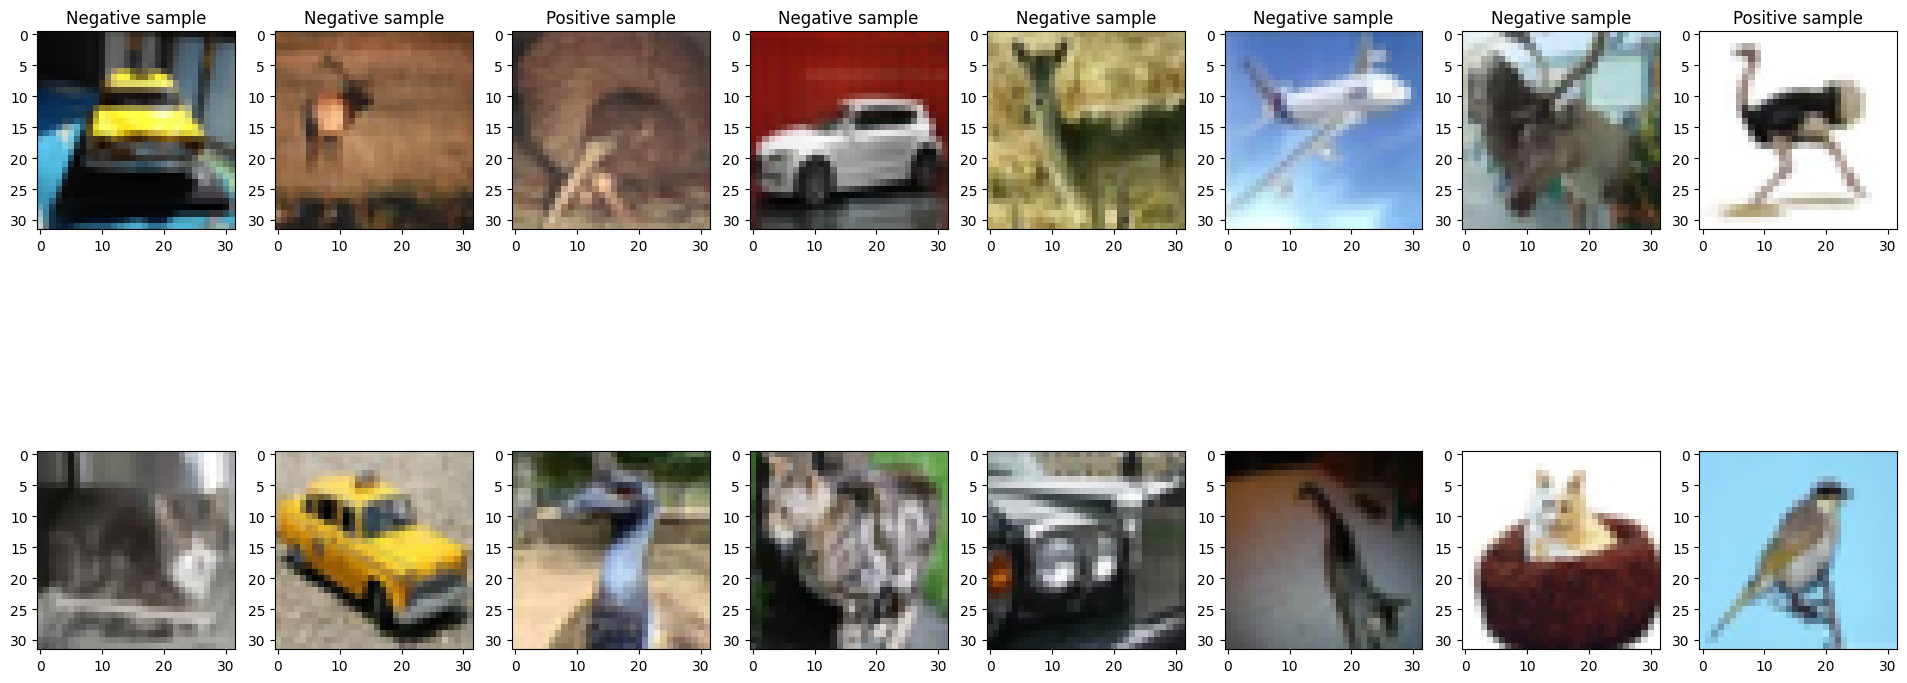

In [ ]:
#fig, ax = plt.subplots(nrows = 2, ncols = 8) # 이전과 다르게 subplot "s"임을 주의
plt.figure(figsize = (24, 10))

for i in range(8): # 8번 반복

  plt.subplot(2, 8, i+1) # 총 8개 그림(1행 8열)을 그리고, 해당 인덱스에 위치시킬 것
  plt.imshow((X1[i].detach().numpy()*255).astype(np.uint8)) # index에 해당하는 그림 출력
  
  if int(Y[i].detach().numpy().reshape(-1)[0]) == 1:
    plt.title('Negative sample') #우리는 1을 Negative sample로 정했음(Img_dset 클래스에서)
  else:
    plt.title('Positive sample')

  plt.subplot(2, 8, i+9) # 총 8개 그림(1행 8열)을 그리고, 해당 인덱스에 위치시킬 것
  plt.imshow((X2[i].detach().numpy()*255).astype(np.uint8)) # index에 해당하는 그림 출력

#Siamese network 구조 설명

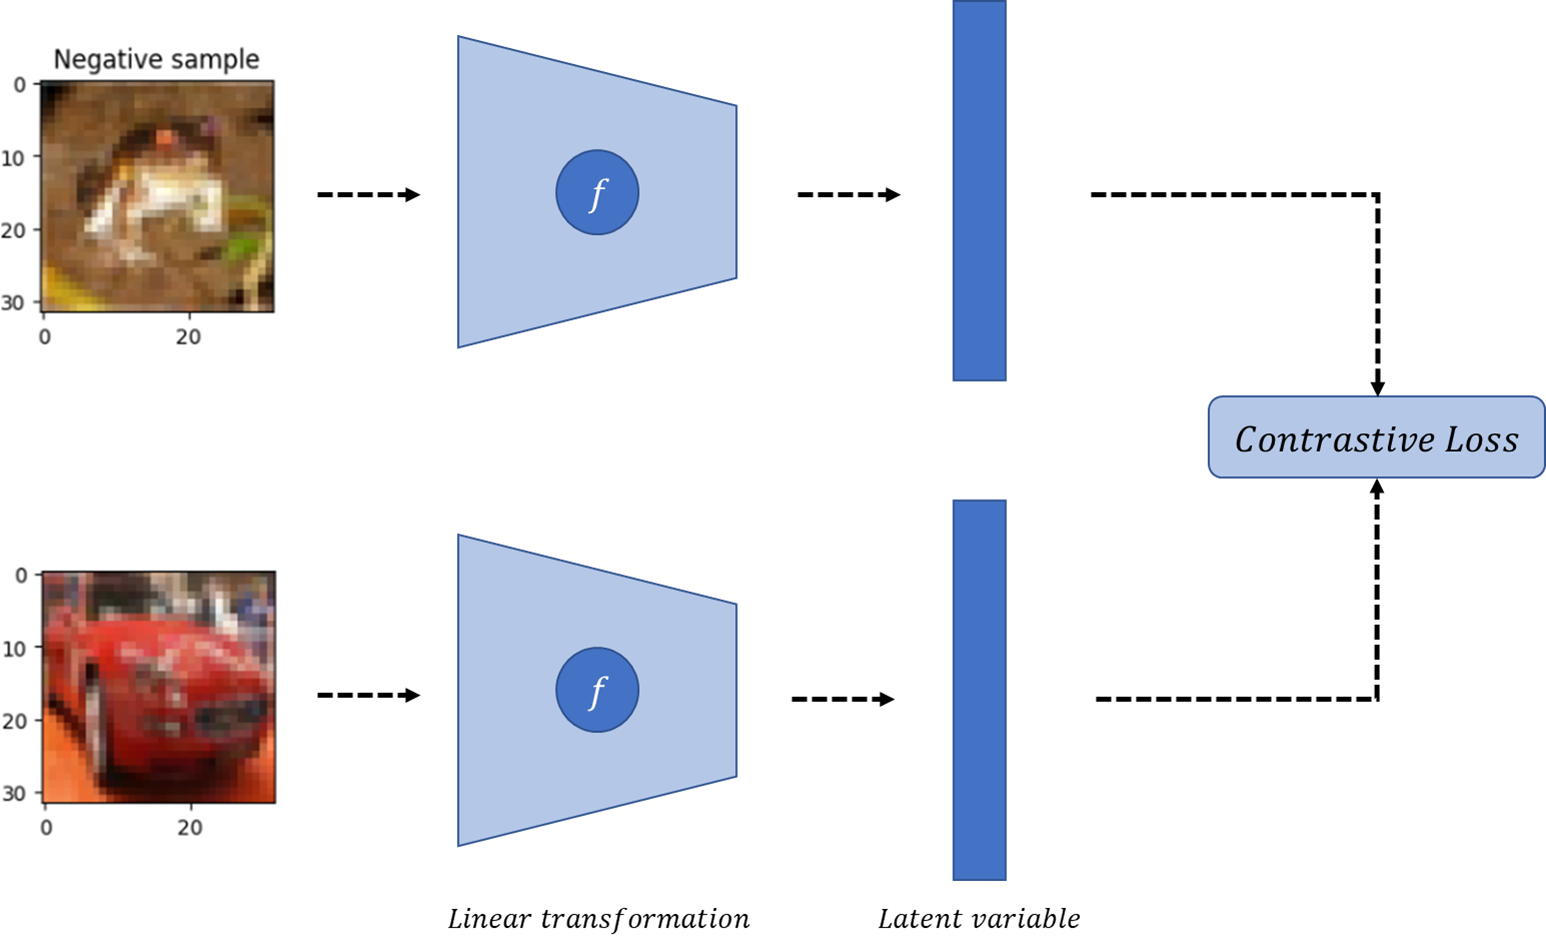

---

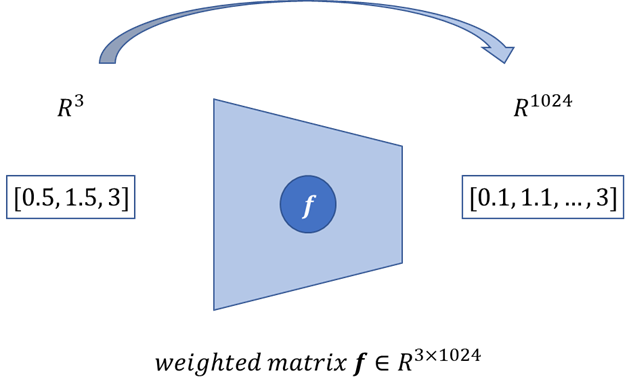

In [ ]:
class Siamese(nn.Module):

  def __init__(self):
    super(Siamese, self).__init__()

    '''
    모델 구조
    연산: Conv 1 -> ReLU -> Max Pooling -> Conv 2 -> ReLU -> Max Pooling -> Conv 3 -> ReLU -> Conv 4 -> ReLU -> Conv 5 -> ReLU -> Max Pooling -> 1-D flatten -> Multi Layer Perceptron
      * (두가지 입력 데이터는 동일한 weighted matrix 사용)
      
    결과물: latent variable
    '''

    self.C1 = nn.Conv2d(in_channels = 3, out_channels = 9, kernel_size = 2, stride = 1, padding = 1) #Conv Layer1
    self.C2 = nn.Conv2d(in_channels = 9, out_channels = 16, kernel_size = 2, stride = 1, padding = 1) #Conv Layer2
    self.C3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 2, stride = 1, padding = 1) #Conv Layer3
    self.C4 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 2, stride = 1, padding = 1) #Conv Layer4
    self.C5 = nn.Conv2d(in_channels = 64, out_channels = 256, kernel_size = 2, stride = 1, padding = 1) #Conv Layer5

    self.pool = nn.MaxPool2d(kernel_size = 2) #Max pooling

    self.L1 = nn.Linear(256, 32) #Multi Layer Perceptron

    self.relu = nn.ReLU() #활성화함수
    
  def forwarding(self, x): # x라는 변수를 입력받음
    '''
    Conv Layer 시작
    처음은 Conv Layer 1에 x라는 변수를 입력함
    그 이후, 출력값을 입력값으로 활용하여 Layer를 통과시킴
    '''
    out = self.C1(x)
    out = self.relu(out)
    out = self.pool(out)

    out = self.C2(out)
    out = self.relu(out)
    out = self.pool(out)

    out = self.C3(out)
    out = self.relu(out)
    out = self.pool(out)

    out = self.C4(out)
    out = self.relu(out)
    out = self.pool(out)

    out = self.C5(out)
    out = self.relu(out)
    out = self.pool(out)

    '''
    Conv Layer 종료
    '''

    #Fully connected layer로 변환
    out = out.reshape(-1, 256)

    #Multi Layer Perceptron
    #256차원 latent vector -> 32차원으로 변환
    out = self.L1(out)

    return out #차원: 32

  def forward(self, x1, x2):
    '''
    Siamese network는 가중치 행렬을 공유함.
    forward 함수에서는 sample된 데이터 두개를 입력받고
    두 데이터를 각각 잠재 벡터로 변환하는 과정을 수행함
    
    이 때, 가중치 행렬을 공유한다는 것은 동일한 가중치 행렬을 사용하여 선형 변환을 수행한다는 뜻임
    '''
    E1 = self.forwarding(x1)
    E2 = self.forwarding(x2)

    return E1, E2

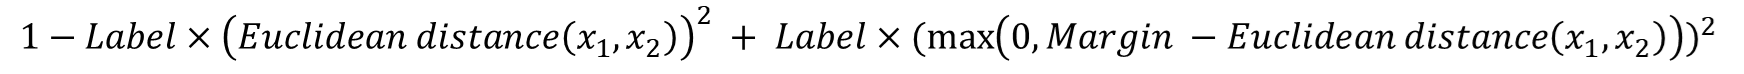

#왜 max(0, Margin - Euclidean distance)를 사용하는지?
* Distance가 만족해야 하는 3가지 가정
 * 삼각부등식 만족
 * 대칭: D(a, b) = D(b, a)
 * ***0보다 항상 커야 함(음의 거리는 존재하지 않음)*** <- max() 함수 원인

##Contrastive Loss
* (A + B 형태로 설명)

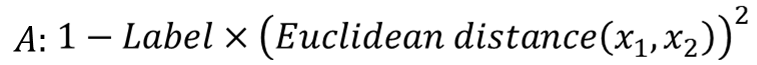

Positive sample을 0이라고 정하면, 1 - Label에 대한 수식만 존재함

이는 입력된 두 데이터의 유클리드 거리이고, 이는 손실함수와 같음

최적화를 통해 손실함수가 0에 수렴하도록 모델의 가중치를 학습한다면

입력된 두 데이터의 거리는 동일한 위치로 변환됨

---

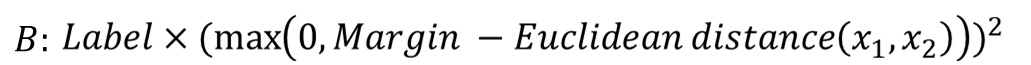

Positive sample이 0이라면, Negative sample이 1이 되므로, 이 경우 Label에 대한 수식만 존재함

두 데이터의 거리를 고정된 절대 값(Margin)으로 수렴시키는 과정을 통해

두 데이터의 거리를 멀어지게 표현할 수 있음

In [ ]:
class Contrastive_Loss(nn.Module):

  def __init__(self):
    super(Contrastive_Loss, self).__init__()
    self.margin = 2.0

  def forward(self, output1, output2, label):
    
    '''
    연산은 1-label, label의 두가지가 더해진 형태임

    label = 0인 경우 -> Loss 값은 torch.mean()의 앞쪽 수식인 두 데이터의 유클리디안 거리의 제곱이 계산되며, 이는 0으로 수렴할 것임(Loss가 최소화 되도록 parameter update)

    반대로, label = 1인 경우 -> Loss 값은 self.margin 값으로 수렴함

    positive sample은 label 0과 같고, negative sample은 label 1과 같음

    positive sample의 유클리디안 거리는 0으로 수렴하고, negative sample의 거리는 self.margin(특정 수치, 이 클래스에서는 2로 지정)으로 수렴함
    '''

    euclidean_distance = nn.functional.pairwise_distance(output1, output2, keepdim = True) # output1, output2의 유클리디안 거리를 계산
    Loss = torch.mean((빈 칸) * torch.pow(euclidean_distance, 2) +
                      (빈 칸) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)) # 수식을 보시고, 적절한 코드를 입력해주세요
                                                                                                      ## Positive가 0인지 혹은 Negative가 0인지는 Img_dset 클래스에 표현했습니다.

    # torch.pow(a, 2)는 a를 제곱한다는 뜻
    # torch.clamp(a, min = 0.0)은 max(0, a)을 수행한다는 것임
    # 거리는 음수가 될 수 없기 때문임(거리가 가지는 기본적인 3가지 성질 중 하나임)

    return Loss

In [ ]:
net = Siamese() # Siamese network 활용

In [ ]:
epochs = 150 # 학습 Cycle을 몇번 반복할 것인지
learning_rate = 0.001 # 도출된 Loss를 어느정도 반영할 것인지
criterion = Contrastive_Loss() # 손실 함수 정의: class로 정의한 Contrastive Loss 사용
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate) # 최적화 함수를 어떤것을 사용할 것인지

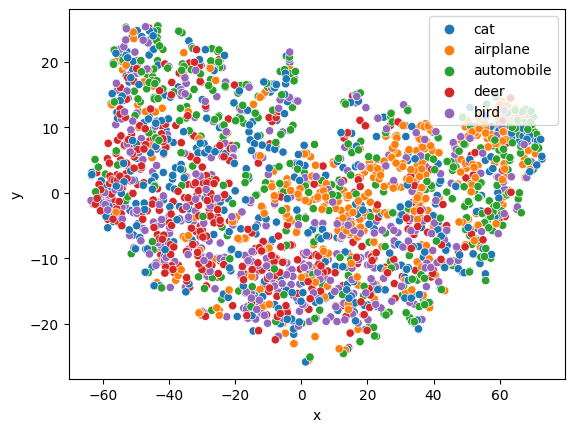

In [ ]:
'''
일단 학습하기 전, 각 이미지 데이터의 초기 벡터의 상태를 시각화하는 과정 수행
'''

with torch.no_grad():
  net.eval() # 학습된 신경망을 검증하기 위한 용도로 변환, 이 과정을 수행하면 메모리를 아낄 수 있다고 알려져 있음

  Latent_vectors = list() # latent vector를 추가해놓기 위한 list 설정
  Animals = list() # 해당 데이터의 class 이름(cat, deer, bird 등)을 저장해놓을 list 설정

  for i, data in enumerate(testloader):

    test_sample = data

    X1 = test_sample[0].squeeze(0).permute(2, 0, 1) # 입력 데이터 차원 변환
    X2 = test_sample[1].squeeze(0).permute(2, 0, 1) # 입력 데이터 차원 변환

    X1_emb, X2_emb = net(X1, X2) # 두 데이터를 latent vector로 변환(네트워크에 입력)

    Y1 = d[test_sample[2].detach().numpy().reshape(1)[0]] # 해당 데이터의 Label과 앞서 정의한 딕셔너리의 수를 매핑시켜, class 이름을 가져오는 과정
    Y2 = d[test_sample[3].detach().numpy().reshape(1)[0]] # 해당 데이터의 Label과 앞서 정의한 딕셔너리의 수를 매핑시켜, class 이름을 가져오는 과정
    
    Latent_vectors.append(X1_emb.detach().cpu().numpy().reshape(-1)) # x1의 latent vector를 list에 추가
    Latent_vectors.append(X2_emb.detach().cpu().numpy().reshape(-1)) # x2의 latent vector를 list에 추가

    Animals.append(Y1) # x1의 정답을 list에 추가
    Animals.append(Y2) # x2의 정답을 list에 추가

Result = pd.DataFrame(Latent_vectors) # 데이터프레임으로 만들기
Result['Label'] = Animals # Label 설정하기

tsne = TSNE() # TSNE라는 알고리즘을 활용하여 고차원 latent vector를 2차원으로 변환(시각화 목적)
xy = tsne.fit_transform(Result.iloc[:, :-1]) # Label이 포함된 열을 제외한 나머지를 입력으로 활용

Result['x'] = xy[:, 0] # 변환된 2차원의 x값 설정
Result['y'] = xy[:, 1] # 변환된 2차원의 y값 설정

sns.scatterplot(x = Result['x'], y = Result['y'], hue = Result['Label']) # 변환된 x, y 데이터를 2차원 산점도로 표현하고, Label에 따라 색깔을 다르게 설정
plt.legend(loc = 'upper right') # 범례는 오른쪽 위로 설정

#위 결과를 통해 확인한 것: 학습되기 전, Latent vector는 서로 구분이 되지 않음

In [ ]:
'''
학습 시작
시간은 약 1시간쯤 걸리는 것으로 확인되기에, 학습하는 과정은 생략하겠습니다.

빈 칸에 적절한 코드를 입력해주세요.

'''

Loss = list() # 손실함수 값을 저장하여, 줄어드는지 확인하기 위함

for epoch in range(epochs):
  net.train()
  for idx, data in enumerate(trainloader):
    
    optimizer.zero_grad()
    
    Sampled_ = data
    X1 = Sampled_[0].squeeze(1).permute(0, 3, 1, 2) # 정의한 신경망에 입력하기 위해 차원 변경
    X2 = Sampled_[1].squeeze(1).permute(0, 3, 1, 2) # 정의한 신경망에 입력하기 위해 차원 변경
    Y = Sampled_[2] # Positive인지, Negative인지를 알려주는 Label

    빈 칸, 빈 칸 = net(빈 칸, 빈 칸) # 신경망 연산을 통해 X1, X2의 Latent Variable 추출

    loss = criterion(빈 칸, 빈 칸, Y) # 손실 함수 계산

    Loss.append(loss.detach().numpy().reshape(1)[0]) # 정의한 List에 손실 함수값 추가

    loss.backward() # 손실 함수값을 바탕으로 역전파 학습 진행

    optimizer.step() # 신경망 파라미터(선형 변환에 사용된 함수의 weight) 최적화

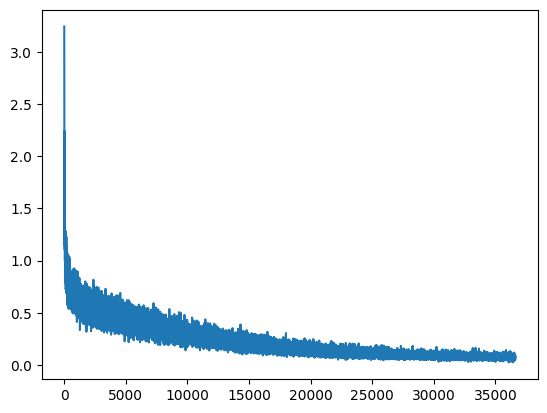

In [ ]:
#손실함수 값 시각화
plt.plot(Loss)

In [ ]:
'''
학습이 완료된 뒤, 잠재 벡터의 시각화
위 과정과 동일하게 진행됨
'''

with torch.no_grad():
  net.eval()

  Latent_vectors = list()
  Animals = list()

  for i, data in enumerate(testloader):

    test_sample = data

    X1 = test_sample[0].squeeze(0).permute(2, 0, 1)
    X2 = test_sample[1].squeeze(0).permute(2, 0, 1)

    X1_emb, X2_emb = net(X1, X2)

    Y1 = d[test_sample[2].detach().numpy().reshape(1)[0]]
    Y2 = d[test_sample[3].detach().numpy().reshape(1)[0]]
    
    Latent_vectors.append(X1_emb.detach().cpu().numpy().reshape(-1))
    Latent_vectors.append(X2_emb.detach().cpu().numpy().reshape(-1))

    Animals.append(Y1)
    Animals.append(Y2)

In [ ]:
Result = pd.DataFrame(Latent_vectors)
Result['Label'] = Animals

In [ ]:
Result

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,Label
0,0.500937,0.088670,-0.185996,0.064925,0.044195,-0.046039,0.276857,0.337124,0.400964,0.521142,...,-0.031947,0.136970,-0.120040,0.257584,-0.035154,0.026130,-0.252018,0.139478,-0.371141,cat
1,0.674381,0.178508,0.066252,0.220793,-0.328740,-0.016088,-0.061104,-0.102574,-0.381948,0.226527,...,-0.176106,-0.037087,0.235577,-0.413060,0.531569,-0.284052,0.750703,0.006182,-0.235038,airplane
2,0.385207,0.124746,-0.063304,0.170987,-0.138854,-0.244980,-0.025454,-0.126861,-0.261752,0.130778,...,-0.119190,-0.055898,0.153804,-0.332647,0.149544,-0.315746,0.676030,-0.042020,-0.063091,airplane
3,0.407182,0.140983,0.159198,0.163199,-0.282935,-0.097420,-0.144263,-0.242828,-0.419024,-0.011266,...,-0.259753,-0.077795,0.270486,-0.535038,0.404923,-0.233998,0.824860,-0.081961,-0.036804,airplane
4,0.576340,0.120638,-0.256514,0.178544,-0.163807,0.215608,0.262810,0.442382,0.096439,0.628584,...,0.480814,0.131314,-0.154308,0.484678,0.397862,-0.268700,-0.206588,0.281223,-0.462531,automobile
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.706534,0.158284,-0.231921,0.227172,-0.155938,-0.123984,0.130968,0.138664,-0.109723,0.498362,...,0.070885,0.023811,0.047505,-0.033865,0.245814,-0.353633,0.417016,0.109947,-0.347804,deer
1996,0.891592,0.206154,0.067106,0.253443,-0.494947,0.406490,0.035395,0.206662,-0.323878,0.509836,...,0.186998,0.068555,0.126302,-0.007748,0.928972,-0.262861,0.348329,0.222270,-0.522050,cat
1997,0.534399,0.123308,-0.168060,0.168941,-0.082878,-0.241439,0.084058,0.020254,-0.090005,0.326072,...,-0.091998,-0.002801,0.077318,-0.177813,0.090052,-0.277904,0.489306,0.020874,-0.203132,bird
1998,0.553228,0.116704,-0.213463,0.252415,-0.468920,0.637622,0.173831,0.534629,-0.333133,0.637211,...,1.139766,0.116888,-0.186830,0.748324,1.007692,-0.557929,-0.153937,0.445390,-0.499531,bird


In [ ]:
tsne = TSNE()

xy = tsne.fit_transform(Result.iloc[:, :-1])

Result['x'] = xy[:, 0]
Result['y'] = xy[:, 1]

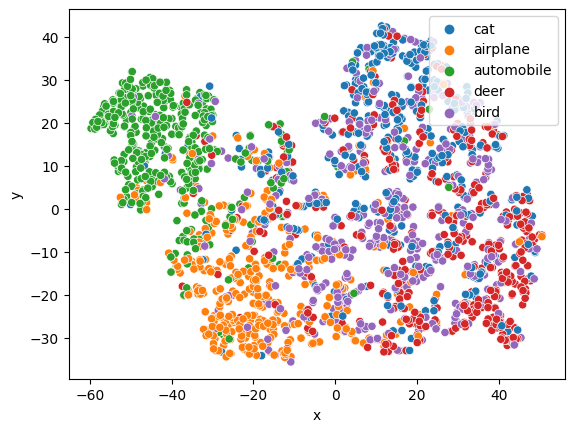

In [ ]:
sns.scatterplot(x = Result['x'], y = Result['y'], hue = Result['Label'])
plt.legend(loc = 'upper right')

###동일한 Label을 가지는 데이터끼리 서로 가깝고, 다른 Label을 가지는 데이터 끼리 서로 멀어지는 것을 확인하였음
* Convolution Network를 더 정교하거나, 하이퍼 파라미터를 조절하여 성능 개선 가능

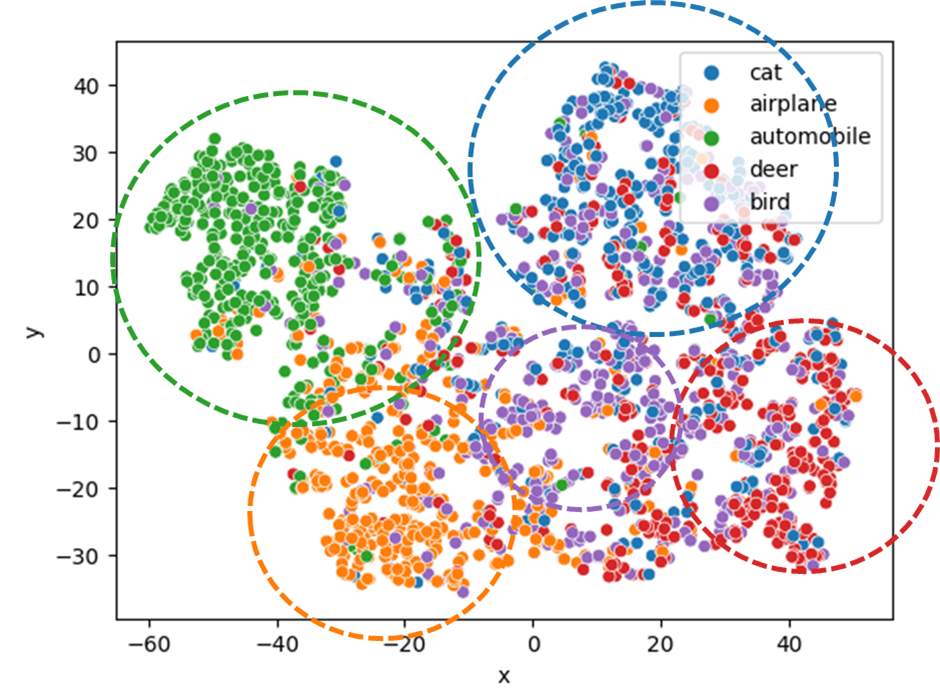

#한계점

---

* Intra-class similarity: class 내에 존재하는 데이터 사이의 유사도(Positive Sample인 경우 문제 발생)
 * 동일한 Sample은 하나의 점에 Mapping -> 동일한 Sample이라도 다양한 특성이 있을 수 있는데, 이를 무시하고 하나의 점으로 표현하는 경우 정보의 손실이 발생할 수 있음
 
---

* Inter-class similarity: class 사이의 유사도(Negative Sample인 경우 문제 발생)
 * Negative Sample은 모두 Margin만큼 멀어지도록 설정하였음.
 * 하지만, ***(강아지, 토끼)*** 의 거리는 ***(강아지, 비행기)*** 의 거리보다 가깝게 설정되어야 함.

---

## 이를 위해 다양한 연구가 진행되고 있음

#활용

**1) K-NN 알고리즘을 활용하여 다중 분류 문제 해결**

**2)  사전 학습된 Latent Variable을 활용하여 다중 분류 문제 해결**

#K-NN

* 입력된 데이터와 거리가 가까운 K개 데이터의 클래스를 기반으로 데이터를 분류

#Latent Variable 활용

* 각 이미지를 (32, 32, 3)의 픽셀 값으로 활용하지 않고, 잠재 공간으로 매핑된 16차원의 벡터를 입력으로 대신 활용하여 예측 모델을 구성

---

#과제
* 본 실습에서 활용한 CIFAR10이 아닌, 다른 데이터를 활용하여 실습을 수행해주시길 바랍니다.